# Extract annotations and data from TCDB

The purpose of this notebook is to extract and format TCDB data for subsequent model annotation.

Additionally, the purpose of this notebook is to extract data for transport protein classification.

## Notebook Requirements:
*  Model genes **must** have the at least one of following annotations stored in the `object.annotation`. Values are expected to be seperated by semicolons. Accepted keys currently include:
    * `"tcdb"`
    * `"uniprot"`
* Note: Requires internet connection to download information from [Transport Classification Database (TCDB)](https://www.tcdb.org/).

### Citation
Saier MH, Reddy VS, Moreno-Hagelsieb G, Hendargo KJ, Zhang Y, Iddamsetty V, Lam KJK, Tian N, Russum S, Wang J, Medrano-Soto A. The Transporter Classification Database (TCDB): 2021 update. Nucleic Acids Res. 2021 Jan 8;49(D1):D461-D467. doi: 10.1093/nar/gkaa1004. PMID: 33170213; PMCID: PMC7778945.

## Setup
### Import packages

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    ANNOTATION_PATH,
    DATABASE_PATH,
    GEM_NAME,
    INTERIM_PATH,
    ROOT_PATH,
    build_string,
    compare_tables,
    explode_column,
    get_annotation_df,
    get_annotation_dirpath,
    get_database_dirpath,
    read_rbc_model,
    show_versions,
    visualize_comparison,
)
from rbc_gem_utils.database.tcdb import TCDB_DB_TAG, download_database_TCDB

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Set notebook options

In [22]:
db_tag = TCDB_DB_TAG
download_database = True
use_interim = False

compare_figsize = (5, 5)
overwrite = True
display_nunique = True
compare = True

# TCDB is best if all mappings are up to date,
# UniProt may not work if TCDB maps to a secondary accession
mapping_key = "uniprot"

## Check TCDB release
* According to the [TCDB FAQ](https://www.tcdb.org/faq.php), updates are usually every week, but it mainly depends on the availability of new data.

In [23]:
database_dirpath = get_database_dirpath(db_tag, use_interim=use_interim)
annotation_dirpath = get_annotation_dirpath(use_interim=use_interim)

# Ensure directories exist
database_dirpath.mkdir(exist_ok=True, parents=True)
annotation_dirpath.mkdir(exist_ok=True, parents=True)

#### Download new files and update database

In [24]:
if download_database:
    download_database_TCDB(database_dirpath=database_dirpath)

## Load identifier and other data tables

In [25]:
df_accessions = pd.read_csv(
    database_dirpath / "acc2tcid.tsv",
    sep="\t",
    header=None,
    names=["uniprot", "tcdb"],
    on_bad_lines="error",
    dtype=str,
)
df_families = pd.read_csv(
    database_dirpath / "families.tsv",
    sep="\t",
    header=None,
    names=["Family", "fam_name"],
    on_bad_lines="error",
    dtype=str,
)
df_superfamilies = pd.read_csv(
    database_dirpath / "listSuperfamilies.tsv",
    sep="\t",
    on_bad_lines="warn",  # Known issue line:7723, field is duplicated so its okay to skip.
    dtype=str,
)

df_families = df_families.merge(
    df_superfamilies,
    left_on="Family",
    right_on="Family",
    how="outer",
).drop_duplicates()
df_families = df_families.rename({c: c.lower() for c in df_families.columns}, axis=1)
df_families

/var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/ipykernel_7480/2582757712.py:17: ParserWarning: Skipping line 8040: expected 5 fields, saw 6

  df_superfamilies = pd.read_csv(


,family,fam_name,#tcid,subfamily,fam_abbreviation,superfamily
0,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.1.1,1.A.1.1,VIC,VIC Superfamily
1,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.1,1.A.1.10,VIC,VIC Superfamily
2,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.10,1.A.1.10,VIC,VIC Superfamily
3,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.11,1.A.1.10,VIC,VIC Superfamily
4,1.A.1,The Voltage-gated Ion Channel (VIC) Superfamily,1.A.1.10.12,1.A.1.10,VIC,VIC Superfamily
...,...,...,...,...,...,...
12813,9.C.5,The Endoplasmic Reticulum/Golgi ATP/ADP or AMP...,NaN,NaN,NaN,NaN
12814,9.C.6,The Mitochondrial Organic Anion Channel (MOAC)...,NaN,NaN,NaN,NaN
12815,9.C.7,"The Low-affinity, Calcium-blocked, Nonspecific...",NaN,NaN,NaN,NaN
12816,9.C.8,The ABC Lignin Precursor Transporters (ALPT) F...,NaN,NaN,NaN,NaN


## Load RBC-GEM model

In [26]:
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,14c1093d0
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Extract current annotations from model

In [27]:
annotation_type = "genes"
annotation_cols = ["tcdb", "uniprot"]

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)

for col in df_model_mappings.columns:
    df_model_mappings = explode_column(df_model_mappings, name=col, sep=";")
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)
df_model_mappings

genes      820
tcdb       150
uniprot    820
dtype: int64


,genes,tcdb,uniprot
0,A4GALT,<NA>,Q9NPC4
1,AARS1,<NA>,P49588
2,AASDHPPT,<NA>,Q9NRN7
3,ABCA1,3.A.1.211.14,O95477
4,ABCA7,3.A.1.211.10,Q8IZY2
...,...,...,...
820,YES1,<NA>,P07947
821,ZDHHC2,<NA>,Q9UIJ5
822,ZDHHC20,8.A.114.1.6,Q5W0Z9
823,ZDHHC3,<NA>,Q9NYG2


### Create data table

In [31]:
df_model_tcdb = df_model_mappings.merge(
    df_accessions,
    left_on=mapping_key,
    right_on=mapping_key,
    how="left",
    suffixes=("_MODEL", ""),
)
df_model_tcdb = df_model_tcdb.drop(
    labels=[x for x in df_model_tcdb.columns if x.endswith("_MODEL")], axis=1
)
df_model_tcdb = df_model_tcdb.dropna().drop_duplicates().reset_index(drop=True)

df_model_tcdb = (
    df_model_tcdb.merge(
        df_families,
        left_on="tcdb",
        right_on="#tcid",
        how="left",
    )
    .rename({c: c.lower() for c in df_families.columns}, axis=1)
    .drop("#tcid", axis=1)
)

for filename in ["pfam", "refseq", "pdb", "go", "getSubstrates"]:
    if filename == "getSubstrates":
        df = pd.read_csv(
            database_dirpath / f"{filename}.tsv",
            sep="\t",
            header=None,
            names=["tcdb", "chebi"],
        )
        df["chebi"] = df["chebi"].str.split("|")
        df["substrate"] = df["chebi"].apply(
            lambda x: build_string([s.split(";")[-1] for s in x])
        )
        df["chebi"] = df["chebi"].apply(
            lambda x: build_string([s.split(";")[0] for s in x])
        )

    else:
        df = pd.read_csv(
            database_dirpath / f"{filename}.tsv",
            sep="\t",
            header=None,
            names=[filename, "tcdb", "family"],
        ).drop("family", axis=1)

    df_model_tcdb = df_model_tcdb.merge(
        df.set_index("tcdb"),
        left_on="tcdb",
        right_on="tcdb",
        how="left",
    ).reset_index(drop=True)

df_model_tcdb = (
    df_model_tcdb.groupby(["genes", "tcdb", "uniprot"], as_index=False)
    .agg(lambda x: build_string(list(x.dropna().unique())))
    .drop_duplicates()
)
df_model_tcdb["subfamily"] = (
    df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+\W\w+\W\w+").explode()
)
df_model_tcdb["family"] = df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+\W\w+").explode()
df_model_tcdb["subclass"] = df_model_tcdb["tcdb"].str.findall(r"^\w+\W\w+").explode()
df_model_tcdb["class"] = df_model_tcdb["tcdb"].str.findall(r"^\w+").explode()
df_model_tcdb = df_model_tcdb.loc[
    :,
    [
        "genes",
        "uniprot",
        "tcdb",
        "subfamily",
        "family",
        "subclass",
        "class",
        "fam_name",
        "fam_abbreviation",
        "superfamily",
        "pfam",
        "refseq",
        "pdb",
        "go",
        "chebi",
        "substrate",
    ],
]
for fam in ["fam_name", "fam_abbreviation"]:
    df_model_tcdb[fam] = df_model_tcdb["family"].replace(
        df_families.set_index("family")[fam].to_dict()
    )

# df_model_tcdb = df_model_tcdb.rename({"go": "GO"}, axis=1)
df_model_tcdb_final = (
    df_model_tcdb.astype(str)
    .groupby(["genes", "tcdb"], as_index=False)
    .agg(lambda x: build_string(x.dropna().unique()))
)


df_model_tcdb_final = df_model_tcdb_final.replace(float("nan"), pd.NA).replace(
    "", pd.NA
)
if display_nunique:
    for col in df_model_tcdb_final.columns:
        df = explode_column(df_model_tcdb_final, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_model_tcdb_final.to_csv(database_dirpath / f"{db_tag}_{GEM_NAME}.tsv", sep="\t")

df_model_tcdb_final

genes: 164
tcdb: 153
uniprot: 164
subfamily: 101
family: 76
subclass: 12
class: 7
fam_name: 76
fam_abbreviation: 39
superfamily: 21
pfam: 97
refseq: 155
pdb: 887
go: 679
chebi: 217
substrate: 209


,genes,tcdb,uniprot,subfamily,family,subclass,class,fam_name,fam_abbreviation,superfamily,pfam,refseq,pdb,go,chebi,substrate
0,ABCA1,3.A.1.211.14,O95477,3.A.1.211,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily,ABC,ArsA ATPase (ArsA) Superfamily,<NA>,<NA>,5XJY,<NA>,CHEBI:22563;CHEBI:53002;CHEBI:16247;CHEBI:3659,anion;amyloid-beta;phospholipid;cholesterol
1,ABCA7,3.A.1.211.10,Q8IZY2,3.A.1.211,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily,ABC,ArsA ATPase (ArsA) Superfamily,PF00005,<NA>,<NA>,GO:0016324;GO:0043190;GO:0010008;GO:0000139;GO...,CHEBI:8150;CHEBI:7242,phospholipid;ceramide
2,ABCB1,3.A.1.201.1,P08183,3.A.1.201,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily,ABC,ArsA ATPase (ArsA) Superfamily,PF00664;PF00005,NP_000918.2,6C0V;6FN1;6FN4;6QEX,GO:0009986;GO:0016021;GO:0005624;GO:0005524;GO...,CHEBI:52155;CHEBI:25697;CHEBI:9494;CHEBI:31781...,mitoTracker Orange;organic cation;tetramethylc...
3,ABCB4,3.A.1.201.3,P21439,3.A.1.201,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily,ABC,ArsA ATPase (ArsA) Superfamily,PF00664;PF00005,NP_000434.1;NP_061337.1,6S7P,GO:0005887;GO:0005624;GO:0005524;GO:0008559;GO...,CHEBI:22868;CHEBI:8128;CHEBI:27375;CHEBI:7887;...,"bile salt;1,2-diacyl-sn-glycero-3-phosphocholi..."
4,ABCB6,3.A.1.210.6,Q9NP58,3.A.1.210,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily,ABC,ArsA ATPase (ArsA) Superfamily,PF00664;PF00005,NP_005680.1,3NH6;3NH9;3NHA;3NHB,GO:0043190;GO:0016021;GO:0005741;GO:0005524;GO...,CHEBI:8337,porphyrin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,TSPO2,9.A.24.1.17,Q5TGU0,9.A.24.1,9.A.24,9.A,9,The Mitochondrial Cholesterol/Porphyrin/5-amin...,nan,<NA>,<NA>,<NA>,<NA>,<NA>,CHEBI:17549,5-aminolevulinic acid
166,VCP,3.A.16.1.1,P55072,3.A.16.1,3.A.16,3.A,3,The Endoplasmic Reticular Retrotranslocon (ER-...,ER-RT,AAA-ATPase Superfamily,PF00004;PF02933;PF02359;PF09336;PF04511;PF0693...,NP_009057.1;NP_001128143.1;NP_077271.1;NP_0056...,3EBB;3HU1;3HU2;3HU3;3QC8;3QQ7;3QQ8;3QWZ;3TIW;4...,GO:0005829;GO:0005783;GO:0005792;GO:0005634;GO...,CHEBI:36080,protein
167,VDAC2,1.B.8.1.12,P45880,1.B.8.1,1.B.8,1.B,1,The Mitochondrial and Plastid Porin (MPP) Family,MPP,Outer Membrane Pore-forming Protein I (OMPP-I)...,<NA>,<NA>,<NA>,<NA>,CHEBI:22563,anion
168,WNK1,8.A.23.1.69,Q9H4A3,8.A.23.1,8.A.23,8.A,8,The Basigin (Basigin) Family,Basigin,Protein Kinase (PK) Superfamily,<NA>,<NA>,<NA>,<NA>,CHEBI:2359,ATP


genes: 164
tcdb: 153
uniprot: 164
pfam: 97
refseq: 155
pdb: 887
go: 679


,genes,tcdb,uniprot,pfam,refseq,pdb,go
0,ABCA1,3.A.1.211.14,O95477,<NA>,<NA>,5XJY,<NA>
1,ABCA7,3.A.1.211.10,Q8IZY2,PF00005,<NA>,<NA>,GO:0000139;GO:0005215;GO:0005524;GO:0005548;GO...
2,ABCB1,3.A.1.201.1,P08183,PF00005;PF00664,NP_000918.2,6C0V;6FN1;6FN4;6QEX,GO:0005515;GO:0005524;GO:0005624;GO:0008559;GO...
3,ABCB4,3.A.1.201.3,P21439,PF00005;PF00664,NP_000434.1;NP_061337.1,6S7P,GO:0005524;GO:0005624;GO:0005887;GO:0006629;GO...
4,ABCB6,3.A.1.210.6,Q9NP58,PF00005;PF00664,NP_005680.1,3NH6;3NH9;3NHA;3NHB,GO:0005524;GO:0005741;GO:0006879;GO:0016021;GO...
...,...,...,...,...,...,...,...
159,TSPO2,9.A.24.1.17,Q5TGU0,<NA>,<NA>,<NA>,<NA>
160,VCP,3.A.16.1.1,P55072,PF00004;PF02359;PF02933;PF03152;PF04511;PF0502...,NP_001128143.1;NP_005650.2;NP_009057.1;NP_0603...,3EBB;3HU1;3HU2;3HU3;3QC8;3QQ7;3QQ8;3QWZ;3TIW;4...,GO:0000502;GO:0004872;GO:0005515;GO:0005524;GO...
161,VDAC2,1.B.8.1.12,P45880,<NA>,<NA>,<NA>,<NA>
162,WNK1,8.A.23.1.69,Q9H4A3,<NA>,<NA>,<NA>,<NA>


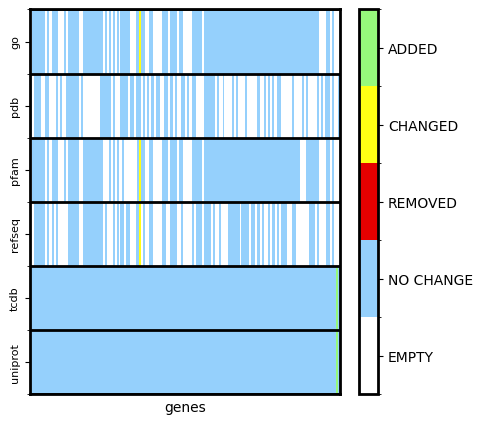

In [32]:
df_annotations = df_model_tcdb_final.loc[
    :, [annotation_type] + ["tcdb", "uniprot", "pfam", "refseq", "pdb", "go"]
]
# Explode and regroup to reduce duplicate mappings to genes
for col in df_annotations.columns:
    df_annotations = explode_column(df_annotations, name=col, sep=";")

df_annotations = df_annotations.groupby(["genes"], as_index=False).agg(
    lambda x: build_string(sorted(x.dropna().unique()))
)
df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )

df_annotations